# Auxiliary SimulationState components: Diagnostics, Randomness, DynamicInput

> **tldr:** This notebook explains how to manage auxiliary simulation state components beyond prognostics. Examples include: diagnostics, randomness, and dynamic inputs (forcings). Each component has a dedicated variable type (`Diagnostic`, `Randomness`, `DynamicInput`) and is managed by a subclasses of base modules (`DiagnosticModule`, `RandomProcessModule`, `DynamicInputModule`). You will learn how to attach Diagnostic modules to inspect intermediate computations (using `with_callback` or explicit definition), how to inject stochasticity using `RandomProcessModule`, and how to provide time-aligned "forcings" using `DynamicInputModule`. Finally, it demonstrates how to manage these components when they are nested or shared within a complex model, using the module_utils.retrieve_subclass_modules utility to find all unique module instances for collective operations.

In the `Model` API intro tutorial we discussed how model prognostics are stored on the model instance. In this notebook we discuss additional components essential for simulations: 'diagnostics', 'randomness', and 'dynamic inputs' (a.k.a., forcings), as well as the system for managing them.

Similar to prognostics, variables for these simulation components are stored on model instances under distinct variable types (`Diagnostic`, `Randomness`, and `DynamicInput`) and are managed by corresponding module subclasses. This design simplifies their initialization and updates.

Outline:
1. How to attach diagnostic computation to model components
2. How to inject stochasticity to model components
3. How to provide time-aligned user inputs to model components
4. What tools does `Model` provide to manage the associated simulation state and what are the associated contracts



In [ ]:
! pip install flax==0.12.0
! pip install --no-cache-dir git+https://github.com/neuralgcm/coordax.git
! pip install --no-cache-dir git+https://github.com/neuralgcm/neuralgcm.git@refs/pull/482/head
! pip install jax_datetime jax_solar fiddle

In [1]:
import dataclasses

import coordax as cx
from flax import nnx
import jax
import jax.numpy as jnp
import jax_datetime as jdt
import matplotlib.pyplot as plt
import numpy as np

from neuralgcm.experimental.atmosphere import idealized_states
from neuralgcm.experimental.core import coordinates
from neuralgcm.experimental.core import dynamic_io
from neuralgcm.experimental.core import diagnostics
from neuralgcm.experimental.core import nnx_compat
from neuralgcm.experimental.core import random_processes
from neuralgcm.experimental.core import feature_transforms
from neuralgcm.experimental.core import parallelism
from neuralgcm.experimental.core import module_utils
from neuralgcm.experimental.core import transforms
from neuralgcm.experimental.core import spherical_transforms
from neuralgcm.experimental.core import typing
from neuralgcm.experimental.core import units

import logging
import warnings
warnings.simplefilter('ignore')
logging.getLogger('jax._src.lib.xla_bridge').addFilter(lambda _: False)

## How to attach diagnostic computation

**Key concepts:**
* `Diagnostic` variables are generally managed by subclasses of `DiagnosticModule`
* Diagnostic modules can be added explicitly or using `with_callback` wrapper method

One approach to adding diagnostics is to follow the same pattern used for prognostics, namely store relevant values in `Diagnostic` variable types. Let us first construct a demo module that we will use for diagnostics demo:

In [5]:
# A simple module with an intermediate step we want to inspect
@nnx_compat.dataclass
class SimpleModule(nnx.Module):
  a: float = 2.0
  b: float = 3.0

  def compute_intermediate(self, x: cx.Field) -> cx.Field:
    return x * self.a  # We will use diagnostic tools to inspect these values.

  def __call__(self, inputs: dict[str, cx.Field]) -> dict[str, cx.Field]:
    x, t = inputs['x'], inputs['t']
    intermediate_val = self.compute_intermediate(x)
    final_result = intermediate_val * self.b
    return {'x': final_result, 't': t + np.timedelta64(1, 'h')}


In [6]:
# Instantiating and running demo module.
simple_module = SimpleModule()
coords = cx.LabeledAxis('x', [0, 1, 2])
x_data = cx.field(jnp.array([10., 20., 30.]), coords)
inputs = {'x': x_data, 't': jdt.to_datetime('2000-01-01')}
simple_outputs = simple_module(inputs)
simple_outputs

{'x': <Field dims=('x',) shape=(3,) axes={'x': LabeledAxis} >,
 't': jax_datetime.Datetime(delta=jax_datetime.Timedelta(days=10957, seconds=3600))}

When interacting with the module explicitly, it is easy enough to expose parts of the computation and inspect intermediate values. This becomes cumbersome when the component is nested deeply inside other modules for several reasons:
* Generating inputs to the module in question might require the user to reconstruct a complex computation
* Diagnostics that span multiple calls require even more care as modules are stateful and multiple calls might lead to a different result

Diagnostics provide a way to collect and expose information about intermediate computation without the need to perform such reconstructions.

The core idea is to modify the module of interest with a wrapper that holds:
1. The original module that will be used to perform the same computation
2. A `DiagnosticModule` that collects diagnostics into `Diagnostic` state

`DiagnosticModule` classes collect and manage the diagnostic state. The base class API is:
```python
class DiagnosticModule(nnx.Module):

  @abc.abstractmethod
  def __call__(self, module_outputs, *in_args, **in_kwargs) -> None:
    """Updates diagnostic state using module_outputs and input arguments."""

  @abc.abstractmethod
  def diagnostic_values(self) -> typing.Pytree:
    """Returns diagnostic values computed from the internal module state."""

  @abc.abstractmethod
  def reset_diagnostic_state(self):
    """Resets the internal diagnostic state."""
```

Inputs to the core `__call__` method are:
1. Outputs of a module method it is configured to inspect;
2. Inputs to the module arguments

The `__call__` method uses these inputs to update relevant `Diagnostic` variables in place.

The other two methods compute final diagnostic values from the internal representation and reset the diagnostic state respectively.

NeuralGCM provides several basic diagnostic modules:
* InstantDiagnostic
* CumulativeDiagnostic

These modules manage an instantenious and cumulative diagnostic values respectively. \
They are parameterized by an `extract_fn(module_outputs, *in_args, **in_kwargs)` callable that computes a single set of values.

Let's see this in practice by inspecting the intermediate value (outputs of `compute_intermediate`) in the SimpleModule. Here we will use `module_utils.with_callaback` to inject the diagnostic computation. This will be done in four steps:
1. Define coordinates for the snapshot of diagnostic values
2. Define a function that will accept output and all args of `compute_intermediate` method and compute diagnostic values
3. Instantiate diagnostic module that will hold `Diagnostic` variables using (1, 2)
4. Use `with_callback` to attach diagnostic module to `simple_model.compute_intermediate` method

In [7]:
# Coordinates for the expected diagnostic value.
diagnostic_coords = {'intermediate': coords}

# Function that extracts just outputs from `compute_intermediate`:
extract_fn = lambda outputs, *args, **kwargs: {'intermediate': outputs}

# Diagnostic instance:
diagnostic = diagnostics.InstantDiagnostic(
    extract=extract_fn,
    extract_coords=diagnostic_coords,
)

# Attaching diagnostic to `compute_intermediate` method on `SimpleModule` module
wrapped_module = module_utils.with_callback(
    simple_module,  # Module with the method we want to compute diagnostic from.
    diagnostic,  # DiagnosticModule to attach.
    'compute_intermediate' # The name of the method to inspect with diagnostic.
)

also_simple_output = wrapped_module(inputs)
diagnostic_values = diagnostic.diagnostic_values()

print(f"Input Data: {inputs['x'].data}")
print(f"Original Output: {simple_outputs['x'].data}")
print(f"Wrapped Output: {also_simple_output['x'].data}")
print(f"Diagnosed value: {diagnostic_values['intermediate'].data}")

Input Data: [10. 20. 30.]
Original Output: [ 60. 120. 180.]
Wrapped Output: [ 60. 120. 180.]
Diagnosed value: [20. 40. 60.]


By inspecting the wrapped module we can find that a reference to `diagnostic` is now stored on the wrapped module.

In [8]:
nnx.display(wrapped_module)

`with_callback` approach provides a fast path for injecting diagnostics, which is ideal for inspection and debugging.

If a diagnostic is known to be required upfront, it can be included as an explicit attribute in the module's definition:

In [13]:
# Module with explicit diagnostic included.

@nnx_compat.dataclass
class SimpleModuleWithDiagnostic(SimpleModule):
  diagnostic: diagnostics.InstantDiagnostic = dataclasses.field(kw_only=True)

  def __call__(self, inputs):
    x, t = inputs['x'], inputs['t']
    intermediate_val = self.compute_intermediate(x)
    self.diagnostic(intermediate_val, x)
    final_result = intermediate_val * self.b
    return {'x': final_result, 't': t + np.timedelta64(1, 'h')}

In [14]:
diagnostic = diagnostics.InstantDiagnostic(
    extract=extract_fn,
    extract_coords=diagnostic_coords,
)
simple_with_diagnostic = SimpleModuleWithDiagnostic(diagnostic=diagnostic)
_ = simple_with_diagnostic(inputs)

In [15]:
diagnostic_values = diagnostic.diagnostic_values()
print(f"Diagnosed value: {diagnostic_values['intermediate'].data}")

Diagnosed value: [20. 40. 60.]


## How to inject stochasticity to model components

**Key concepts:**
* `RandomProcessModule` subclasses provides an interface for managing `Randomness` state variables.
* Random processes feature api similar to an independent model implementing `unconditional_sample`, `advance` and `state_values`

One powerful approach to modeling unresolved dynamics is to introduce stochasticity to the computation, driven by a prescribed random process. The NeuralGCM codebase provides the RandomProcessModule API to help define these random processes and maintain their associated state. The underlying state is wrapped in `Randomness` variable type. For examples let's have a look at two different random processes:
1. NormalUncorrelated - uncorrelated samples from normal distribution
2. GaussianRandomField - spatially and temporally correlated gaussian process

In [24]:
sim_units = units.get_si_units()
grid = coordinates.LonLatGrid.T42()
ylm_grid = coordinates.SphericalHarmonicGrid.T42()
ylm_map = spherical_transforms.FixedYlmMapping(
    grid,
    ylm_grid,
    partition_schema_key=None,
    mesh=parallelism.Mesh(),
    radius=sim_units.radius,
)
uncorrelated = random_processes.NormalUncorrelated(
    grid, mean=0.0, std=1.0, rngs=nnx.Rngs(0)
)
gaussian_random_process = random_processes.GaussianRandomField(
    ylm_map, 3600, sim_units, '10 hours', '500 km', 1.0, rngs=nnx.Rngs(1)
)

In [25]:
rng = cx.field(jax.random.key(0))
uncorrelated.unconditional_sample(rng)
gaussian_random_process.unconditional_sample(rng)

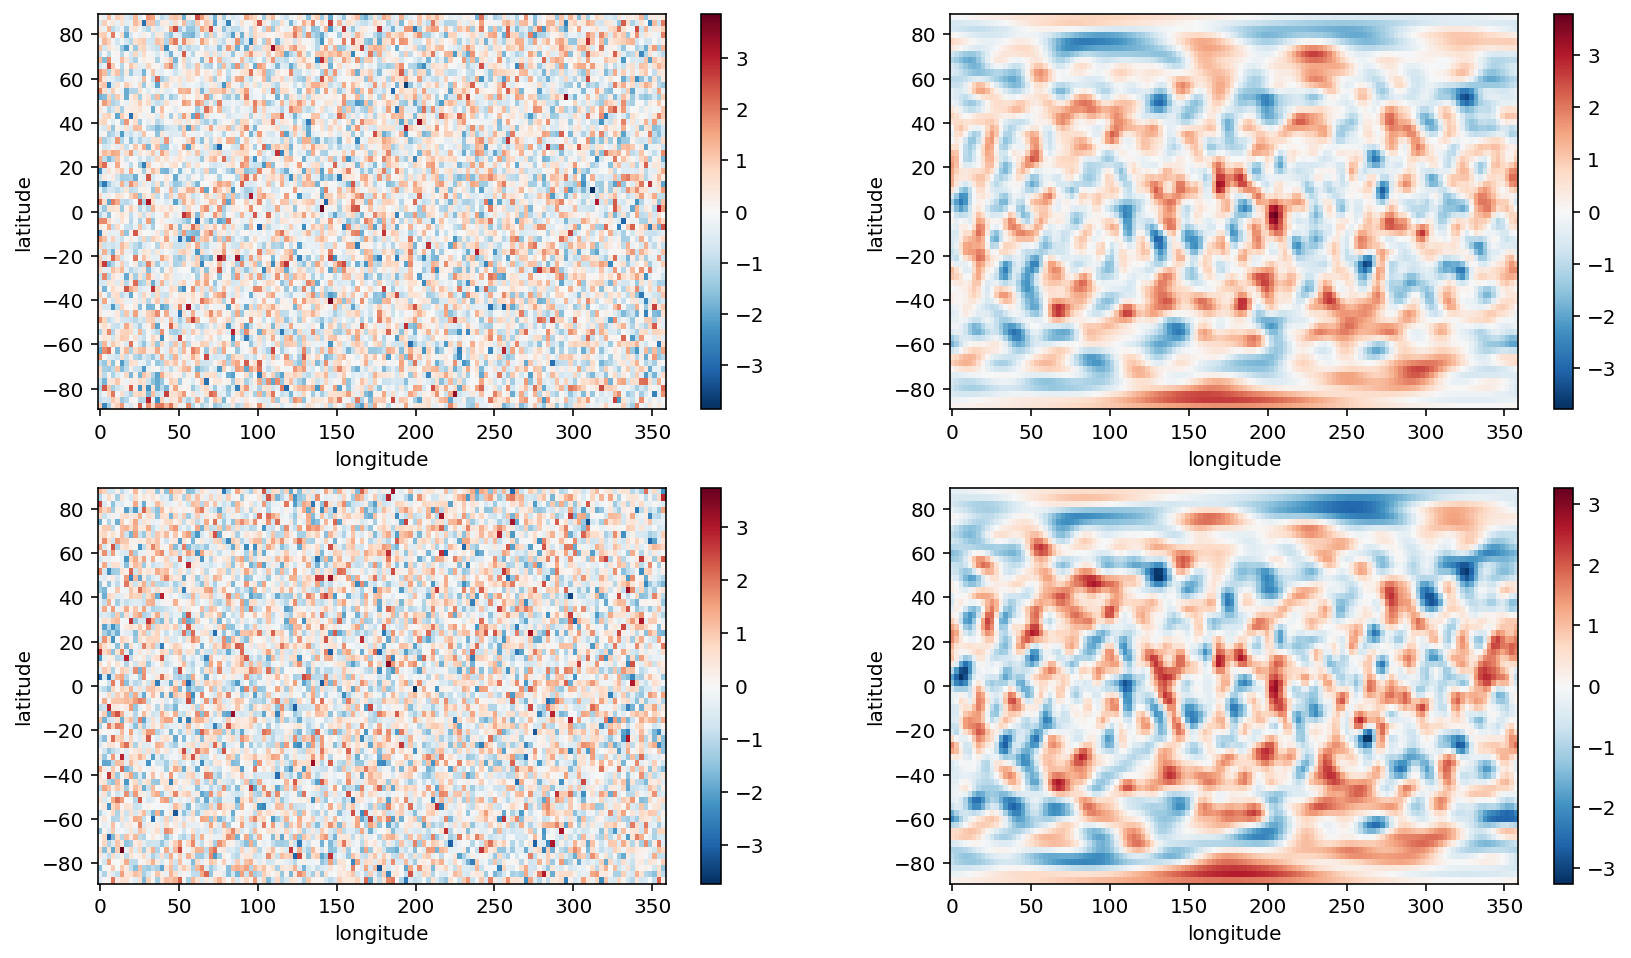

In [26]:
uncorrelated_randomness = uncorrelated.state_values()
gaussian_process_randomness = gaussian_random_process.state_values()
fig, axarray = plt.subplots(2, 2, figsize=(14, 8))
uncorrelated_randomness.to_xarray().plot(x='longitude', y='latitude', ax=axarray[0, 0])
gaussian_process_randomness.to_xarray().plot(x='longitude', y='latitude', ax=axarray[0, 1])

# call advance
uncorrelated.advance()
gaussian_random_process.advance()
uncorrelated_randomness = uncorrelated.state_values()
gaussian_process_randomness = gaussian_random_process.state_values()
uncorrelated_randomness.to_xarray().plot(x='longitude', y='latitude', ax=axarray[1, 0])
gaussian_process_randomness.to_xarray().plot(x='longitude', y='latitude', ax=axarray[1, 1])

As mentioned before, the state of the random process is stored on the module. These modules can be shared by multiple model components to draw values from.

Example usage of such modules include:
* Stochastic perturbation of parameterization tendencies
* Random features used by neural networks

## How to ingest time-aligned user inputs into model components

**Key concepts:**
* `DynamicInputModule` subclasses provide mechanisms for storing and accessing time-aware user data.
* Values in Dynamic inputs are accessed by the `time` argument

Simulations are also frequently driven by external user inputs, sometimes known as "forcings," that models conditions on.

In NeuralGCM codebase such functionality is provided by `DynamicInputModule` subclasses. They take responsibility for storing user inputs wrapped in a `DynamicInput` variable type and provide two methods:
1. `update_dynamic_inputs(dynamic_inputs: dict[str, Fields]) -> None:` - that updates values stored by the module
2. `__call__(time: jdt.Datetime) -> Fields:` that retrieves values associated with `time` argument

Different modules may use different structure of data provided by the user and implement their own time alignment mechanics. The simplest version is the `DynamicInputSlice` module, which stores user-provided, time-indexed values and retrieves the closest match for a requested time.

Let's take see this module in action

In [27]:
grid = coordinates.LonLatGrid.T42()
dynamic_input = dynamic_io.DynamicInputSlice(
    keys_to_coords={'a': grid},  # specifies data coords (modulo the time axis).
    observation_key='abc',  # specifies data_source key associated with data.
)

# Defining user provided data for field 'a'.
data_for_times = np.arange(2)[:, None, None]
data = {'abc': {'a': data_for_times * np.ones(grid.shape)}}
t_delta_between_data = np.timedelta64(6, 'h')
timedelta = coordinates.TimeDelta(np.arange(2) * t_delta_between_data)
dt_and_grid = cx.compose_coordinates(timedelta, grid)
in_data = jax.tree.map(lambda x: cx.field(x, dt_and_grid), data)

# All DynamicInputSlice configuration require `time` key to associated `time`
# values with `timedelta` axis on the data.
t0 = jdt.to_datetime('2000-01-01')
time = t0 + timedelta.fields['timedelta']
in_data['abc']['time'] = time

# updating values stored on the module.
dynamic_input.update_dynamic_inputs(in_data)

# probing values returned for different time arguments.
print(dynamic_input(t0 + np.timedelta64(1, 'h'))['a'].data.max())  # t0 closer.
print(dynamic_input(t0 + np.timedelta64(3, 'h'))['a'].data.max())  # t0 closer.
print(dynamic_input(t0 + np.timedelta64(6, 'h'))['a'].data.max())  # t0 + 6.
print(dynamic_input(t0 + np.timedelta64(30, 'h'))['a'].data.max())  # t0 + 6.

0.0
0.0
1.0
1.0


Let's update the `time` associated with the underlying dynamic data by shifting it one day forward. This will affect the outputs for the same time queries:

In [28]:
in_data['abc']['time'] = time + cx.field(jdt.Timedelta(days=1))
dynamic_input.update_dynamic_inputs(in_data)
# no longer returns 1 since t0 + 24 is not past t0 + 24 + 6;
print(dynamic_input(t0 + np.timedelta64(24, 'h'))['a'].data.max())
print(dynamic_input(t0 + np.timedelta64(30, 'h'))['a'].data.max())

0.0
1.0


We can see that the state associated with inputs is stored on the module

In [29]:
nnx.state(dynamic_input, typing.DynamicInput)

State({
  'data': DynamicInput( # 16,384 (131.1 KB)
    value={'a': <Field (
      dims=('timedelta', 'longitude', 'latitude'),
      shape=(2, 128, 64),
      axes={
        'timedelta': <TimeDelta[0:00:00, 6:00:00]>,
        'longitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=0),
        'latitude': SelectedAxis(coordinate=LonLatGrid(<5 fields...>), axis=1),
      },
    )}
  ),
  'time': DynamicInput( # 4 (16 B)
    value=<Field dims=('timedelta',) shape=(2,) axes={'timedelta': TimeDelta} >
  )
})

## Mechanisms for managing multiple components with additional simulation state

**Key concepts:**
* Model components can contain many, potentially shared, modules that keep track of additional simulation state variables
* Collective calls to all subcomponents are facilitated by `module_utils.retrieve_subclass_modules` helper

As `Model` instances grow, managing the initialization and manipulation of many nested, stateful sub-components becomes cumbersome.

Furthermore, multiple components may need to be shared across different parts of the model.

Let's build an example where two sub-components might use the same set of dynamic inputs.

In [30]:
@nnx_compat.dataclass
class RadiationParameterization(nnx.Module):
  co2_features: feature_transforms.DynamicInputFeatures

  def __call__(self, inputs):
    co2_feature_values = self.co2_features(inputs)
    return co2_feature_values  # would actually return radiation values.


@nnx_compat.dataclass
class CarbonCycleParameterization(nnx.Module):
  co2_features: feature_transforms.DynamicInputFeatures

  def __call__(self, other_inputs):
    co2_feature_values = self.co2_features(other_inputs)
    return co2_feature_values  # would actually return carbon cycle updates.


@nnx_compat.dataclass
class CombinedParameterization(nnx.Module):
  radiation: RadiationParameterization
  carbon_cycle: CarbonCycleParameterization

  def __call__(self, inputs):
    ...

If we instantiate a single dynamic input feature module and share it across the two sub-parameterizations, then combined parameterization will store only 1 copy of CO2 forcing.

In [31]:
t0 = jdt.to_datetime('2000-01-01')
timedelta = coordinates.TimeDelta(np.arange(12) * np.timedelta64(30, 'D'))
time = t0 + timedelta.fields['timedelta']
values = cx.field(
    370*np.exp(0.0063 * timedelta.deltas / np.timedelta64(365, 'D')), timedelta
)
co2_forcing_values = {'global': {'co2': values, 'time': time}}

co2_forcing = dynamic_io.DynamicInputSlice({'co2': cx.Scalar()}, observation_key='global')
co2_features = feature_transforms.DynamicInputFeatures(['co2'], co2_forcing)
radiation = RadiationParameterization(co2_features)
carbon_cycle = CarbonCycleParameterization(co2_features)  # same co2_features.
combined = CombinedParameterization(radiation, carbon_cycle)

In [32]:
nnx.state(combined, typing.DynamicInput)

State({
  'carbon_cycle': {
    'co2_features': {
      'dynamic_input_module': {
        'data': DynamicInput( # 1 (4 B)
          value={'co2': <Field dims=('timedelta',) shape=(1,) axes={'timedelta': TimeDelta} >}
        ),
        'time': DynamicInput( # 2 (16 B)
          value=<Field dims=('timedelta',) shape=(1,) axes={'timedelta': TimeDelta} >
        )
      }
    }
  }
})

To update the values we have several options:
1. update the underlying module directly
2. update using any of the references

In [33]:
co2_forcing.update_dynamic_inputs(co2_forcing_values)
inputs_a = {'time': cx.field(jdt.to_datetime('2000-01-01'))}
inputs_b = {'time': cx.field(jdt.to_datetime('2000-04-01'))}
inputs_c = {'time': cx.field(jdt.to_datetime('2000-09-01'))}
print(combined.radiation(inputs_a)['co2'].data)
print(combined.radiation(inputs_b)['co2'].data)
print(combined.radiation(inputs_c)['co2'].data)
print(combined.carbon_cycle(inputs_c)['co2'].data)

370.0
370.5752
371.5359
371.5359


We could have also called
```
carbon_cycle.co2_features.dynamic_input_module.update_dynamic_inputs(co2_forcing_values)
```
to achieve the same effect, but that requires remembering the model structure.
This approach also runs into a danger of calling the same module multiple times.

To update all unique components of a specific type (e.g., DynamicInputModule) exactly once, use the `module_utils.retrieve_subclass_modules` helper function:

In [34]:
print(module_utils.retrieve_subclass_modules(
    combined, dynamic_io.DynamicInputModule
))

[DynamicInputSlice( # DynamicInput: 36 (192 B)
  keys_to_coords={'co2': Scalar()},
  observation_key='global',
  time_axis=0,
  time=DynamicInput( # 24 (96 B)
    value=<Field dims=('timedelta',) shape=(12,) axes={'timedelta': TimeDelta} >
  ),
  data=DynamicInput( # 12 (96 B)
    value={'co2': <Field dims=('timedelta',) shape=(12,) axes={'timedelta': TimeDelta} >}
  )
)]


This identifies that the CombinedParameterization contains only 1 unique instance. Here's what happens if each parameterization carries a distinct module:

In [35]:
co2_forcing_radiation = dynamic_io.DynamicInputSlice({'co2': cx.Scalar()}, observation_key='atm')
co2_features_radiation = feature_transforms.DynamicInputFeatures(['co2'], co2_forcing_radiation)

co2_forcing_carbon = dynamic_io.DynamicInputSlice({'co2': cx.Scalar()}, observation_key='soil')
co2_features_carbon = feature_transforms.DynamicInputFeatures(['co2'], co2_forcing_carbon)

radiation = RadiationParameterization(co2_features_radiation)
carbon_cycle = CarbonCycleParameterization(co2_features_carbon)
combined_distinct = CombinedParameterization(radiation, carbon_cycle)
print(module_utils.retrieve_subclass_modules(
    combined_distinct, dynamic_io.DynamicInputModule
))

[DynamicInputSlice( # DynamicInput: 3 (20 B)
  keys_to_coords={'co2': Scalar()},
  observation_key='soil',
  time_axis=0,
  time=DynamicInput( # 2 (16 B)
    value=<Field dims=('timedelta',) shape=(1,) axes={'timedelta': TimeDelta} >
  ),
  data=DynamicInput( # 1 (4 B)
    value={'co2': <Field dims=('timedelta',) shape=(1,) axes={'timedelta': TimeDelta} >}
  )
), DynamicInputSlice( # DynamicInput: 3 (20 B)
  keys_to_coords={'co2': Scalar()},
  observation_key='atm',
  time_axis=0,
  time=DynamicInput( # 2 (16 B)
    value=<Field dims=('timedelta',) shape=(1,) axes={'timedelta': TimeDelta} >
  ),
  data=DynamicInput( # 1 (4 B)
    value={'co2': <Field dims=('timedelta',) shape=(1,) axes={'timedelta': TimeDelta} >}
  )
)]


This utility is used by several `Model` helper functions to orchestrate calls to all subcomponents of a specific type.
* `update_dynamic_inputs` - calls `update_dynamic_input` on all `DynamicInputModele` components
* `initialize_random_processes` - calls `unconditional_sample` on all `RandomProcessModule` components
* `reset_diagnostic_state` - calls `reset_diagnostic_state` on all `DiagnosticModule` components
* `diagnostic_values` - calls `diagnostic_values` on all `DiagnosticModule` components